In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['text.usetex'] = True

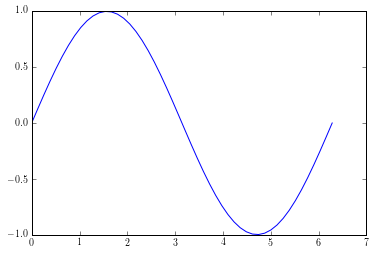

In [2]:
x = np.linspace(0,2*np.pi)
plt.plot(x, np.sin(x))

La dernière valeur de x est: {{x[-1]}}